In [39]:
import gymnasium
import pybullet
from robot_descriptions.loaders.pybullet import load_robot_description

In [44]:
pybullet.connect(pybullet.GUI)

0

In [45]:
robot = load_robot_description("ur5_description")
#C:\Users\anshu\anaconda3\envs\robotics-mva\Library\share\example-robot-data\robots\ur_description\urdf
#robot = pybullet.loadURDF("ur5_robot.urdf")

In [46]:
for j in range(0, 7):
    pybullet.setJointMotorControl2(robot, j, pybullet.VELOCITY_CONTROL, force=0)
    pybullet.setJointMotorControl2(robot, j, pybullet.TORQUE_CONTROL, force=50)
pybullet.stepSimulation()

()

In [47]:
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [48]:
def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [50]:
num_joints = pybullet.getNumJoints(robot)
print(num_joints)
for i in range(num_joints): 
    print(pybullet.getJointInfo(robot, i))

12
(0, b'world_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'base_link', (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), -1)
(1, b'shoulder_pan_joint', 0, 7, 6, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'shoulder_link', (0.0, 0.0, 1.0), (0.0, 0.0, 0.089159), (0.0, 0.0, 0.0, 1.0), 0)
(2, b'shoulder_lift_joint', 0, 8, 7, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'upper_arm_link', (0.0, 1.0, 0.0), (0.0, 0.13585, 0.0), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 1)
(3, b'elbow_joint', 0, 9, 8, 1, 0.0, 0.0, -3.14159265359, 3.14159265359, 150.0, 3.15, b'forearm_link', (0.0, 1.0, 0.0), (0.0, -0.1197, 0.14499999999999996), (0.0, 0.0, 0.0, 1.0), 2)
(4, b'wrist_1_joint', 0, 10, 9, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_1_link', (0.0, 1.0, 0.0), (0.0, 0.0, 0.14225), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 3)
(5, b'wrist_2_joint', 0, 11, 10, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_

In [56]:
# Define a sinusoidal trajectory
dt     = 0.01 # Simulation time-step
p_des = np.random.rand(6)*2*np.pi - np.pi
p_i = np.zeros(6)

p_gain = np.array([10.0, 1.0, 3.0, 1.0, 1.0, 1.0]) # Proportional gain
#d_gain = np.array([10.0, 4.0, 10.0, 1.0, 1.0, 1.0])*0.01 # Derivative gain
d_gain = 2*np.sqrt(p_gain)

error = np.zeros(6)
error_old = np.zeros(6)

control_steps = 5000

log_ang = np.zeros((control_steps, 6))
log_ang_err = np.zeros((control_steps, 6))
cf = np.zeros((control_steps, 6))


# Run the control loop
for i in range(control_steps):
    
    # Get the joint state
    for j in range(1, 7):
        p_i[j-1], _, _, _ = p.getJointState(robot, j)

    # Calculate the control input
    error_old = error
    error = p_des - p_i#%(2*np.pi)
    error_d = (error - error_old)/dt
    control_force = p_gain * error + d_gain * error_d # PD control
    #print(p_i, control_force)
    control_force = np.clip(control_force, -50, 50) # Saturation; to model the torque limit of the motors
    
    # Run the simulation for one time-step
    for j in range(1, 7):
        p.setJointMotorControl2(robot, j, p.TORQUE_CONTROL, force=control_force[j-1])
    p.stepSimulation()
    
    # Store the data for plotting
    log_ang[i] = p_i
    log_ang_err[i] = error
    cf[i] = control_force

In [61]:
p_des, p_i

(array([-2.67080378, -2.6810871 ,  2.24941351,  2.27122197, -0.8496174 ,
        -0.63643082]),
 array([-2.67072307, -2.67054731,  2.249389  ,  2.27185946, -0.84996834,
        -0.6363227 ]))

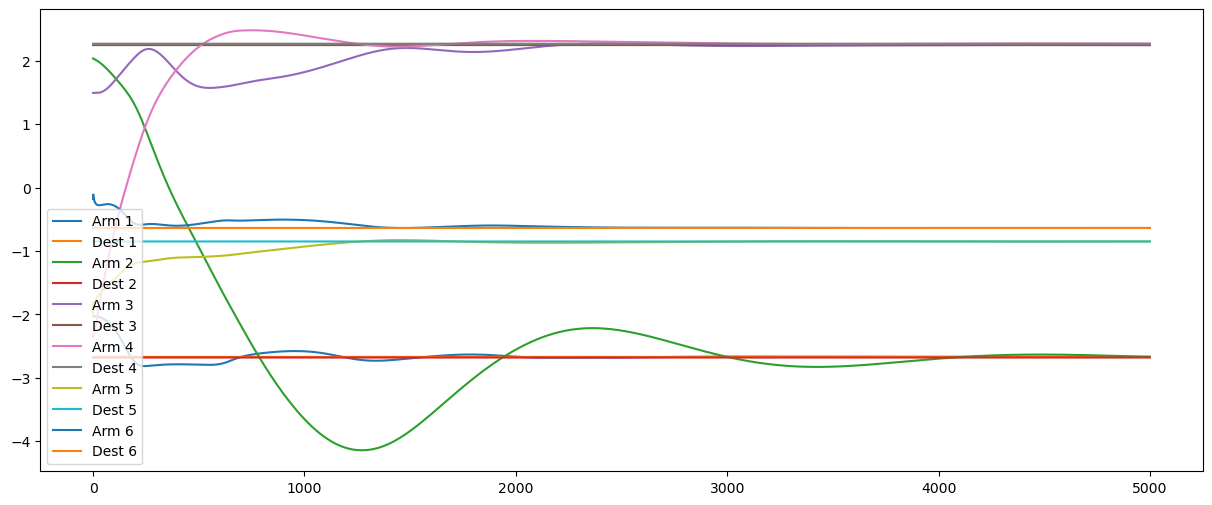

In [58]:
plt.figure(6, figsize=(15, 6))
for j in range(1, 7):
    plt.plot(log_ang[:, j-1], label='Arm '+str(j))
    plt.plot(p_des[j-1]*np.ones(control_steps), label='Dest '+str(j))
#plt.plot(p_des, label="Desired position")
#plt.ylim([-2,2])
#plt.plot(cf, label="Control Input")
plt.legend()
plt.show()


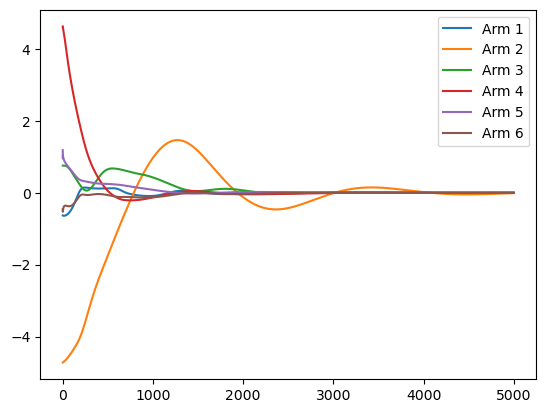

In [59]:
plt.figure(7)
for j in range(1, 7):
    plt.plot(log_ang_err[:, j-1], label='Arm '+str(j))
#plt.plot(p_des, label="Desired position")
#plt.ylim([-2,2])
#plt.plot(cf, label="Control Input")
plt.legend()
plt.show()


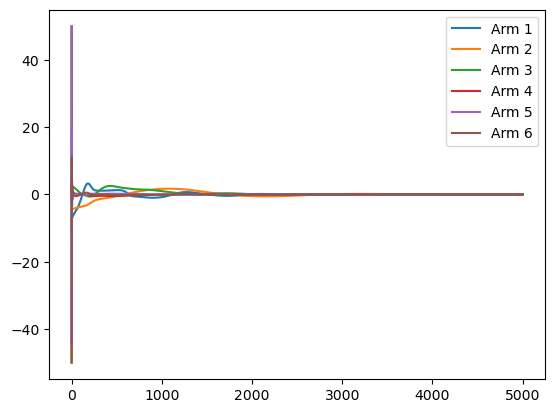

In [60]:
plt.figure(8)
for j in range(1, 7):
    plt.plot(cf[:, j-1], label='Arm '+str(j))
#plt.plot(p_des, label="Desired position")
#plt.ylim([-2,2])
#plt.plot(cf, label="Control Input")
plt.legend()
plt.show()


In [62]:
pybullet.disconnect()

In [ ]:
cf[:-10]

array([[ 6.18563484e+00,  8.06288882e+00,  1.17134302e+01,
        -8.68062869e+00,  1.94854674e+00,  3.33523953e+00],
       [ 2.90135163e+00,  2.70077442e+00,  1.94920313e+00,
        -4.29115076e+00,  9.41698481e-01,  1.15913679e+00],
       [ 2.88738724e+00,  2.70458033e+00,  1.94489277e+00,
        -4.24143208e+00,  9.10882329e-01,  7.35866011e-01],
       ...,
       [ 1.81071819e-01,  5.14298607e-01,  8.25557842e-01,
         3.22500043e-03, -5.39547199e-05,  4.71760279e-05],
       [ 1.81155081e-01,  5.14306648e-01,  8.25557842e-01,
         3.21665843e-03, -5.40371036e-05,  4.69119255e-05],
       [ 1.81223081e-01,  5.14298082e-01,  8.25557842e-01,
         3.20746861e-03, -5.41019888e-05,  4.66396905e-05]])

In [19]:
p1 = np.array([1.0, 0.5])
p2 = np.array([0.5, 1.0])
pt_des = p1 # or p2

valid, [theta1, theta2] = inverse_kinematics(pt_des[0], pt_des[1], 1, 1)


dt     = 0.001 # simulation time-step
p_gain = 200 # Proportional gain
d_gain = 50 # Derivative gain
error  = 0
error_old = 0
desired_pos = np.array([theta1, theta2])
for _ in range(1000):
    pos1, _, _, _ = p.getJointState(robot,1)
    pos2, _, _, _ = p.getJointState(robot,2)
    pos = np.array([pos1, pos2])
    error_old = error
    error = desired_pos - pos
    error_d = (error - error_old)/dt
    control_force = p_gain * error + d_gain * error_d
    p.setJointMotorControlArray(robot, [1,2], p.TORQUE_CONTROL, forces=control_force)
    p.stepSimulation()

    
# Check if the robot has reached the desired position
pos1, _, _, _ = p.getJointState(robot, 1)
pos2, _, _, _ = p.getJointState(robot, 2)
pt_act = forward_kinematics(pos1, pos2, 1, 1)

print(pt_des)
print(pt_act)

[1.  0.5]
[-0.8831633377051846, -1.7940326353222553]
